In [13]:
import jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp


In [14]:
def get_modes_power_scalar(UG, λ, a1 = jnp.array([1.0, 0.0]), a2 = jnp.array([0.0, 1.0]), 
                           eps = 1,mu = 1):
    """
    Compute the power of each mode (m,n) per unit cell (Eq. 1.1.55)

    Parameters
    ----------
    UG: 2D array with the perodic field (Eq.1.1.40), in uv coordinates 
    λ: wavelength of the propagating medium
    a1, a2: primitive lattice vectors  (Eq.1.1.33)
    mu, eps : magnetic permeability and electric permittivity (default 1).
    """
    Nv,Nu = UG.shape
    J = jnp.abs(a1[0]*a2[1] - a1[1]*a2[0]) #Jacobian
    b1 = 2*jnp.pi / J * jnp.array([ a2[1], -a2[0] ])  #primitive reciprocal vectors (Eq. 1.1.36)
    b2 = 2*jnp.pi / J * jnp.array([-a1[1],  a1[0] ])
    m_, n_ = jnp.arange(Nu)-Nu//2 , jnp.arange(Nv)-Nv//2 # diffraction orders indexing
    mm_, nn_ = jnp.meshgrid(m_, n_)

    #Grating Equation
    Gmn_x, Gmn_y = mm_*b1[0] + nn_*b2[0], mm_*b1[1] + nn_*b2[1]
    senθx, senθy = 𝜆*Gmn_x/(2*np.pi),  𝜆*Gmn_y/(2*jnp.pi)
    #discard evanescent modes
    mask = (jnp.where( senθy**2 + senθx**2 >1, 0 , 1 ))
    Cmn = jnp.fft.fftshift(jnp.fft.fft2(UG))*(1/(Nv*Nu)) # (Eq. 1.1.42)
    pow_mode = 0.5* jnp.sqrt(eps/mu) * Cmn*jnp.conjugate(Cmn)* J * mask # (Eq. 1.1.55)
    return mm_, nn_, pow_mode

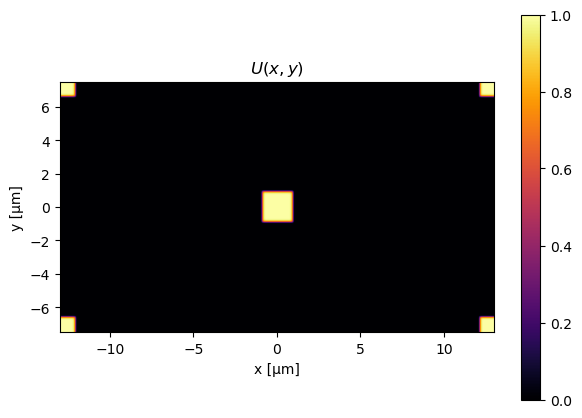

In [15]:
Nx = Ny = 1024*2
a = 15
Λx = (a*2*jnp.cos(2*jnp.pi/12))
Λy = (a*2*jnp.sin(2*jnp.pi/12))
Ny = int(jnp.round(Λy/Λx * Nx))
dx = Λx/Nx
dy = Λy/Ny
x = dx*(jnp.arange(Nx)-Nx//2)
y = dy*(jnp.arange(Ny)-Ny//2)
xx, yy = jnp.meshgrid(x, y)   
U = 0
w= 0.06 * a
for i in range(0,6):
    x0 = a * jnp.sin(2*jnp.pi/6 * i)
    y0 = a * jnp.cos(2*jnp.pi/6 * i)
    U += jnp.exp(- 1/2 * ((xx - x0)/ (w))**20) * jnp.exp(- 1/2 * ((yy - y0)/ (w))**20)
x0 = 0
y0 = 0
U += jnp.exp(- 1/2 * ((xx - x0)/ (w))**20) * jnp.exp(- 1/2 * ((yy - y0)/ (w))**20)



fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(np.real(U), cmap ='inferno', extent=[float(x[0]), float(x[-1]+dx), float(y[0]), float(y[-1]+dy)])
ax.set_title("$U(x,y)$")
ax.set_xlabel("x [µm]")
ax.set_ylabel("y [µm]")
fig.colorbar(im, orientation = 'vertical')
plt.show()



In [16]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

def interpolate_to_uv(f_data, x, y, a, uv_resolution=100):
    """
    Interpolates a periodic 2D function f_data, defined on a grid given by x and y,
    onto a uniform (u,v) grid over [0,1] x [0,1] using the transformation:
    
        u = (sqrt(3)*x)/(3a) + y/a
        v = (sqrt(3)*x)/(3a) - y/a

    Assumes that f(x,y) is periodic with period lengths given by:
        period_x = x[-1] - x[0]
        period_y = y[-1] - y[0]

    Parameters:
    -----------
    f_data : 2D numpy array
        Function values evaluated on the (x,y) grid. Expected shape is (len(y), len(x)).
    x : 1D numpy array
        x-coordinates of the original grid.
    y : 1D numpy array
        y-coordinates of the original grid.
    a : float
        Parameter in the transformation.
    uv_resolution : int, optional
        Number of grid points along each axis in the (u,v) grid (default is 100).

    Returns:
    --------
    U, V : 2D numpy arrays
        Meshgrid arrays for u and v coordinates in the unit square.
    f_uv : 2D numpy array
        Interpolated function values on the (u,v) grid.
    """
    # Set up the interpolator. We assume the provided grid covers one period.
    # The ordering of axes in f_data is (y, x).
    interpolator = RegularGridInterpolator((y, x), f_data, bounds_error=False, fill_value=None)

    # Create a uniform (u,v) grid.
    u = np.linspace(0, 1, uv_resolution)
    v = np.linspace(0, 1, uv_resolution)
    U, V = np.meshgrid(u, v)

    # Invert the transformation:
    #   u = (sqrt(3)*x)/(3a) + y/a  and  v = (sqrt(3)*x)/(3a) - y/a,
    # yields:
    #   x = (a*sqrt(3)/2) * (u + v)
    #   y = (a/2) * (u - v)
    X_new = (a * np.sqrt(3) / 2) * (U + V)
    Y_new = (a / 2) * (U - V)

    # For periodicity, map (X_new, Y_new) back to the base period.
    period_x = x[-1] - x[0]
    period_y = y[-1] - y[0]
    X_new_mod = x[0] + np.mod(X_new - x[0], period_x)
    Y_new_mod = y[0] + np.mod(Y_new - y[0], period_y)

    # Prepare points for interpolation.
    # Note: points need to be in (y, x) order.
    points = np.array([Y_new_mod.ravel(), X_new_mod.ravel()]).T
    f_uv = interpolator(points).reshape(U.shape)
    return U, V, f_uv


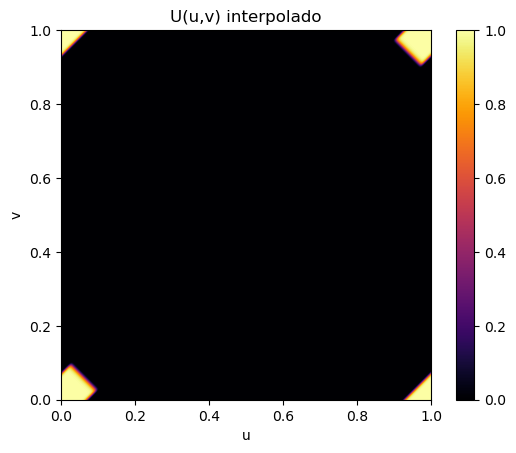

In [17]:

uu, vv, U_uv = interpolate_to_uv(np.array(U), x, y, a, uv_resolution=512*4)

plt.imshow(U_uv, extent=[0, 1, 0, 1],   aspect='equal', cmap = 'inferno')
plt.title("U(u,v) interpolado")
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()

In [18]:
a1 = np.array([a*np.cos(30/180*np.pi), a*np.sin(30/180*np.pi)]) 
a2 = np.array([a*np.cos(30/180*np.pi), -a*np.sin(30/180*np.pi)])
Juv = jnp.abs(a1[0]*a2[1] - a1[1]*a2[0])
λ = 1
dv = 1/U_uv.shape[0]
du = 1/U_uv.shape[1]
mm_, nn_, pow_mode = get_modes_power_scalar(U_uv,  λ, a1, a2)

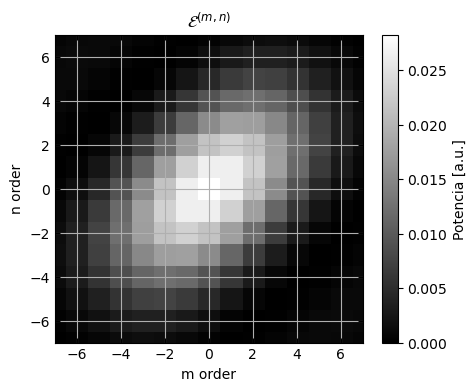

In [19]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)


Nx_ = mm_[0,:]
Ny_ = nn_[:,0]
im = ax.imshow((jnp.abs(pow_mode)), origin = 'lower', cmap ='gray', interpolation  = 'none', extent=[Nx_[0]-0.5, Nx_[-1] +0.5, Ny_[0] -0.5, Ny_[-1] + 0.5],  vmin = 0)

ax.set_title(r"$\mathcal{E}^{\left(m,n\right)}$")
ax.set_xlabel("m order")
ax.set_ylabel("n order")
ax.set_xlim([-7,7])
ax.set_ylim([-7,7])
plt.grid()
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)

cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Potencia [a.u.]')

plt.show()
